###### Neccessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random
import math
import re
from IPython.display import clear_output
%matplotlib inline

###### Loading Dataset

In [2]:
tweets_df = pd.read_csv('Tweets.csv')
tweets_df = tweets_df.rename(columns={"airline_sentiment": "label"})

###### Analysing Dataset

In [3]:
tweets_df.head()

,label,text
0,neutral,@USAirways Is there a phone line to call into ...
1,positive,@united Bag was finally delivered and intact. ...
2,positive,@usairways Thanks to Kevin and team at F38ish ...
3,negative,"@AmericanAir Yes, talked to them. FLL says is ..."
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
tweets_df.shape

(14640, 2)

Classes

In [5]:
classes = sorted(tweets_df['label'].unique())
classes

['negative', 'neutral', 'positive']

**Dataset is skewed towards Negative class**

Text(0.5, 0, 'Labels')

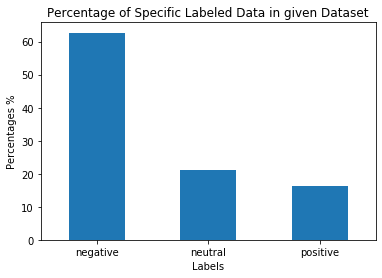

In [6]:
ax = (tweets_df['label'].value_counts(normalize=True)*100).plot(
        kind="bar", title='Percentage of Specific Labeled Data in given Dataset')
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('Percentages %')
ax.set_xlabel('Labels')

### Dataset Splitting (Stratified) Function

In [7]:
def split_dataset(df, classes, split=80, rand_factor=0):
    '''
        Performs stratified split
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
            
        classes: list
            List of unique classes of shape (k, ), where k is the number of classes
        
        split: int
            Spliting point
            
        rand_factor = int
            Number of times dataset should be randomized
        
        Returns
        --------
        train_df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
            
        test_df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
        '''
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    
    label_count = df['label'].value_counts()
    for i, c in enumerate(classes):
        temp_df = df[df['label'] == i].reset_index(drop=True)
        split_index = int(label_count[i] * (split/100))
        train_df = pd.concat([temp_df[:split_index], train_df], ignore_index=True)
        test_df = pd.concat([temp_df[split_index:], test_df], ignore_index=True)
        
    if rand_factor:
        for _ in range(rand_factor):
            train_df = train_df.sample(frac=1).reset_index(drop=True)
            test_df = test_df.sample(frac=1).reset_index(drop=True)
    
    return train_df, test_df

### Dataset Preprocessing Functions

* Label Encoding

In [8]:
def LabelEncoder(df):
    '''
        Encodes Labels
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
        '''
    df['label'] = df['label'].astype('category')
    df['encoded_labels'] = df['label'].cat.codes

In [9]:
# Encoding Labels
LabelEncoder(tweets_df)
tweets_df = tweets_df.drop(columns=["label"])
tweets_df = tweets_df.rename(columns={"encoded_labels": "label"})
tweets_df.head()

,text,label
0,@USAirways Is there a phone line to call into ...,1
1,@united Bag was finally delivered and intact. ...,2
2,@usairways Thanks to Kevin and team at F38ish ...,2
3,"@AmericanAir Yes, talked to them. FLL says is ...",0
4,@VirginAmerica and it's a really big bad thing...,0


In [10]:
encoded_classes = [i for i in range(len(classes))]
encoded_classes

[0, 1, 2]

* Bag of Words (BOW)

In [11]:
def clean_text(text, stopwords):
    '''
        Cleans Text
        
        Arguments
        ---------
        text : str            
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords 
        
        Returns
        --------
        cleaned_text: list
            Array of shape (x, ), where x is the number of words in the sentence
    '''
    cleaned_text = ""

    cleaned_text = re.sub("[^\w]", " ", text) # Removing punctautions
    cleaned_text = cleaned_text.lower() # Converting to lower case
    cleaned_text = cleaned_text.split() # Tokenizing
    # Removing Stopwords
    if stopwords:
        cleaned_text = [x for x in cleaned_text if x not in stopwords]
        
    return cleaned_text

def get_vocab(texts, stop_words):
    '''
        Extracts stopwords and vobcabulary from texts on the basis of a threshold
        
        Arguments
        ---------
        texts : list
            Array of shape (m, ), where m is number examples
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords
        
        Returns
        --------            
        vocab : list
            Array of shape (n, ), where n is the number of words in vocabulary
    '''
    vocab = list()

    for text in texts:
        cleaned_text = clean_text(text, stop_words)
        for word in cleaned_text:
            if word not in vocab:
                vocab.append(word)
    vocab = sorted(vocab)
    return vocab

def BOW_for_class(texts, vocab, stop_words):
    '''
        Calculates count of each word in vocab for the given texts
        
        Arguments
        ---------
        texts : list
            Array of shape (m, ), where m is number examples
            
        vocab : list
            Array of shape (n, ), where n is the number of words in vocabulary
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords
        
        Returns
        --------            
        BOW : dictionary
            Dictionary of shape (n, ), where n is the number of words in vocabulary
    '''
    BOW = dict()
    
    # Initializing BOW with keys from vocab and zero count
    BOW = {w:0 for w in vocab}
    for text in texts:
        cleaned_text = clean_text(text, stop_words)
        for word in cleaned_text:
            BOW[word] += 1
            
    return BOW

### Training Function

In [12]:
def trainNB(doc, classes, stop_words=None):
    '''
        Calculates log prior, log likelihood and vocabulary for given doc and classes 
        
        Arguments
        ---------
        docs : Dataframe
            Dataframe of shape (m, 2), where m is number examples, each with 'text' and 'label'
            
        classes : list
            Array of shape (n, ), where n is the number of classes
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords
        
        Returns
        --------            
        log_prior: dict
            Dictionary of shape (x, ), where x is the number of classes
            
        log_likelihood: dict
            Dictionary of shape (x, y), where x is the number of classes, y is the number of words in vocabulary
            
        vocab: list
            Array of shape (x, ), where x is the number of words in vocabulary
    '''
    log_prior, log_likelihood, vocab = dict(), dict(), list()
    
    N_doc = doc.shape[0]
    vocab = get_vocab(doc['text'], stop_words)
    big_doc = dict()
    for c in classes:
        N_c = doc['label'][doc['label'] == c].count()
        log_prior[c] = np.log(N_c / N_doc)
        
        big_doc[c] = BOW_for_class(doc['text'][doc['label'] == c], vocab, stop_words)
        
        log_likelihood[c] = dict()
        N_tokens_c = sum(big_doc[c].values())
        for word in vocab:
            log_likelihood[c][word] = np.log((big_doc[c][word] + 1) / (N_tokens_c + len(vocab)))
    
    return log_prior, log_likelihood, vocab

### Testing Function

In [13]:
def test_doc(doc, log_prior, log_likelihood, classes, vocab, stop_words):
    '''
        Predicts class for given doc 
        
        Arguments
        ---------
        doc : str
            Given text
            
        log_prior: dict
            Dictionary of shape (x, ), where x is the number of classes
            
        log_likelihood: dict
            Dictionary of shape (x, y), where x is the number of classes, y is the number of words in vocabulary
            
        classes : list
            Array of shape (n, ), where n is the number of classes
            
        vocab: list
            Array of shape (x, ), where x is the number of words in vocabulary
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords
        
        Returns
        --------            
        pred_c: int
            Encoded label of predicted class
    '''
    pred_c = None
    cleaned_doc = clean_text(doc, stop_words)
    Sum = np.zeros(len(classes))
    for c in classes:
        Sum[c] = log_prior[c]
        for word in cleaned_doc:
            if word in vocab:
                Sum[c] += log_likelihood[c][word]
    pred_c = np.argmax(Sum)
    return pred_c

def testNB(docs, log_prior, log_likelihood, classes, vocab, stop_words=None):
    '''
        Predicts class for given doc 
        
        Arguments
        ---------
        docs : Dataframe
            Dataframe of shape (m, 2), where m is number examples, each with 'text' and 'label'
            
        log_prior: dict
            Dictionary of shape (x, ), where x is the number of classes
            
        log_likelihood: dict
            Dictionary of shape (x, y), where x is the number of classes, y is the number of words in vocabulary
            
        classes : list
            Array of shape (n, ), where n is the number of classes
            
        vocab: list
            Array of shape (x, ), where x is the number of words in vocabulary
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords
        
        Returns
        --------            
        cm: Numpy Array
            Numpy Array of shape (c, c), where c is the number of classes            
    '''
    cm = np.zeros((len(classes), len(classes)))
    
    for _, data in docs.iterrows():
        pred_c = test_doc(data['text'], log_prior, log_likelihood, classes, vocab, stop_words)
        cm[pred_c][data['label']] += 1
    
    return cm

### Evaluation Fuctions

In [14]:
def get_tp(cm, y):
    '''
    Calculates True Positives of given class w.r.t. other classes

    Arguments
    ---------
    cm: numpy array
        Array of shape (k, k), where k is the number of classes

    y: int
        Label of given classe

    Returns
    --------
    tp: int
        True Positives
    '''
    tp = 0
    tp = cm[y][y]
    return tp

def get_tn(cm, y):
    '''
    Calculates True Negatives of given class w.r.t. other classes

    Arguments
    ---------
    cm: numpy array
        Array of shape (k, k), where k is the number of classes

    y: int
        Label of given classe

    Returns
    --------
    tn: int
        True Negatives
    '''
    tn = 0
    for i in range(len(cm)):
        if i != y:
            for j in range(len(cm)):
                if j != y:
                    fp += cm[i][j]
    return tn                

def get_fp(cm, y):
    '''
    Calculates False Positives of given class w.r.t. other classes

    Arguments
    ---------
    cm: numpy array
        Array of shape (k, k), where k is the number of classes

    y: int
        Label of given classe

    Returns
    --------
    fp: int
        False Positives
    '''
    fp = 0
    for j in range(len(cm)):
        if j != y:
            fp += cm[y][j]
    return fp

def get_fn(cm, y):
    '''
    Calculates False Negatives of given class w.r.t. other classes

    Arguments
    ---------
    cm: numpy array
        Array of shape (k, k), where k is the number of classes

    y: int
        Label of given classe

    Returns
    --------
    fn: int
        False Negatives
    '''
    fn = 0
    for i in range(len(cm)):
        if i != y:
            fn += cm[i][y]
    return fn

def get_precision(cm):
    '''
    Calculates Macro Precision

    Arguments
    ---------
    cm: numpy array
        Array of shape (k, k), where k is the number of classes

    Returns
    --------
    precision: float
        Macro Precision
    '''
    precision = 0
    for i in range(len(cm)):
        temp = (get_tp(cm, i) + get_fp(cm, i))
        if temp:
            precision += (get_tp(cm, i) / temp)
    precision /= len(cm)
    return precision

def get_recall(cm):
    '''
    Calculates Macro Recall

    Arguments
    ---------
    cm: numpy array
        Array of shape (k, k), where k is the number of classes

    Returns
    --------
    recall: float
        Macro Recall
    '''
    recall = 0
    for i in range(len(cm)):
        temp = (get_tp(cm, i) + get_fn(cm, i))
        if temp:
            recall += (get_tp(cm, i) / temp)
    recall /= len(cm)
    return recall

def evaluation_matrix(cm, classes):
    '''
        Plots confusion matrix and calculates Macro accuracy, precision, recall, f1 score

        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
            
        classes: list
            Array of encoded labels of shape (c, ), where c is the number of classes
    '''
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
              columns = [i for i in classes])
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="BuPu")
    plt.show()
    # Calculating Accuracy, Precision, Recall and F1 Score
    accuracy = np.sum(np.array([get_tp(cm, i) for i in range(len(cm))])) / np.sum(cm)
    precision = get_precision(cm)
    recall = get_recall(cm)
    f1_score = ((2*recall*precision) / (recall + precision))
    print("\n\nAccuracy = %.3f" % (accuracy))
    print("Precision = %.3f" % (precision))
    print("Recall = %.3f" % (recall))
    print("F1 Score = %.3f" % (f1_score)) 

### Main Processing

In [15]:
# We are not removing any stopwords from the Documents
stop_words = None

**Splitting**

In [16]:
# Train-Test Split
full_train_df, test_df = split_dataset(tweets_df, classes, rand_factor=2)

**Training**

In [17]:
# Training
log_prior, log_likelihood, V = trainNB(full_train_df, encoded_classes, stop_words=stop_words)

**Testing**

In [18]:
# Testing
cm = testNB(test_df, log_prior, log_likelihood, encoded_classes, V, stop_words=stop_words)

### Evaluation Report

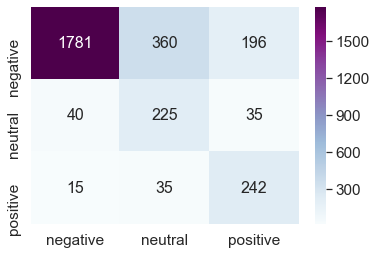



Accuracy = 0.767
Precision = 0.780
Recall = 0.615
F1 Score = 0.688


In [19]:
evaluation_matrix(cm, classes)

We have used **Macro Scores** to evaluate our skewed dataset